## Part 2: Clinical Application

### Contents
Fill out this notebook as part 2 of your final project submission.

**You will have to complete the Code (Load Metadata & Compute Resting Heart Rate) and Project Write-up sections.**  

- [Code](#Code) is where you will implement some parts of the **pulse rate algorithm** you created and tested in Part 1 and already includes the starter code.
  - [Imports](#Imports) - These are the imports needed for Part 2 of the final project. 
    - [glob](https://docs.python.org/3/library/glob.html)
    - [os](https://docs.python.org/3/library/os.html)
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
  - [Load the Dataset](#Load-the-dataset)  
  - [Load Metadata](#Load-Metadata)
  - [Compute Resting Heart Rate](#Compute-Resting-Heart-Rate)
  - [Plot Resting Heart Rate vs. Age Group](#Plot-Resting-Heart-Rate-vs.-Age-Group)
- [Project Write-up](#Project-Write-Up) to describe the clinical significance you observe from the **pulse rate algorithm** applied to this dataset, what ways/information that could improve your results, and if we validated a trend known in the science community. 

### Dataset (CAST)

The data from this project comes from the [Cardiac Arrythmia Suppression Trial (CAST)](https://physionet.org/content/crisdb/1.0.0/), which was sponsored by the National Heart, Lung, and Blood Institute (NHLBI). CAST collected 24 hours of heart rate data from ECGs from people who have had a myocardial infarction (MI) within the past two years.<sup>1</sup> This data has been smoothed and resampled to more closely resemble PPG-derived pulse rate data from a wrist wearable.<sup>2</sup>

1. **CAST RR Interval Sub-Study Database Citation** - Stein PK, Domitrovich PP, Kleiger RE, Schechtman KB, Rottman JN. Clinical and demographic determinants of heart rate variability in patients post myocardial infarction: insights from the Cardiac Arrhythmia Suppression Trial (CAST). Clin Cardiol 23(3):187-94; 2000 (Mar)
2. **Physionet Citation** - Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals (2003). Circulation. 101(23):e215-e220.

-----

### Code
#### Imports

When you implement the functions, you'll only need to you use the packages you've used in the classroom, like [Pandas](https://pandas.pydata.org/) and [Numpy](http://www.numpy.org/). These packages are imported for you here. We recommend you don't import other packages outside of the [Standard Library](https://docs.python.org/3/library/) , otherwise the grader might not be able to run your code.

In [1]:
import glob
import os

import numpy as np
import pandas as pd

#### Load the dataset

The dataset is stored as [.npz](https://docs.scipy.org/doc/numpy/reference/generated/numpy.savez.html) files. Each file contains roughly 24 hours of heart rate data in the 'hr' array sampled at 1Hz. The subject ID is the name of the file. You will use these files to compute resting heart rate.

Demographics metadata is stored in a file called 'metadata.csv'. This CSV has three columns, one for subject ID, age group, and sex. You will use this file to make the association between resting heart rate and age group for each gender.

Find the dataset in `../datasets/crisdb/`

In [14]:
hr_filenames = glob.glob('datasets/crisdb/*.npz')

#### Load Metadata
Load the metadata file into a datastructure that allows for easy lookups from subject ID to age group and sex.

In [15]:
metadata_filename = 'datasets/crisdb/metadata.csv'

# Load the metadata file into this variable.
with open(metadata_filename, 'r') as f:
    metadata = pd.read_csv(f)
metadata.head()

,subject,age,sex
0,e198a,20-24,Male
1,e198b,20-24,Male
2,e028b,30-34,Male
3,e028a,30-34,Male
4,e061b,30-34,Male


#### Compute Resting Heart Rate
For each subject we want to compute the resting heart rate while keeping track of which age group this subject belongs to. An easy, robust way to compute the resting heart rate is to use the lowest 5th percentile value in the heart rate timeseries.

In [17]:
def AgeAndRHR(metadata, filename):

    # Load the heart rate timeseries
    hr_data = np.load(filename)['hr']
    
    # Compute the resting heart rate from the timeseries by finding the lowest 5th percentile value in hr_data
    rhr = np.percentile(hr_data, q=5)

    # Find the subject ID from the filename.
    subject = os.path.basename(filename).split('.')[0]

    # Find the age group for this subject in metadata.
    age_group = metadata[metadata.subject == subject].age.values[0]
    
    # Find the sex for this subject in metadata.
    sex = metadata[metadata.subject == subject].sex.values[0]

    return age_group, sex, rhr

df = pd.DataFrame(data=[AgeAndRHR(metadata, filename) for filename in hr_filenames],
                  columns=['age_group', 'sex', 'rhr'])

df.head()

,age_group,sex,rhr
0,70-74,Male,54.595576
1,55-59,Male,71.117208
2,50-54,Male,68.571429
3,55-59,Male,70.458716
4,40-44,Male,52.294841


#### Plot Resting Heart Rate vs. Age Group
We'll use [seaborn](https://seaborn.pydata.org/) to plot the relationship. Seaborn is a thin wrapper around matplotlib, which we've used extensively in this class, that enables higher-level statistical plots.

We will use [lineplot](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) to plot the mean of the resting heart rates for each age group along with the 95% confidence interval around the mean. Learn more about making plots that show uncertainty [here](https://seaborn.pydata.org/tutorial/relational.html#aggregation-and-representing-uncertainty).

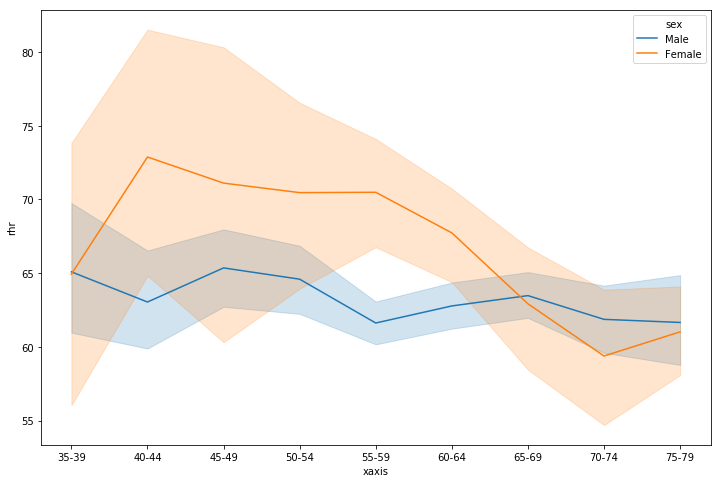

In [19]:
import seaborn as sns
from matplotlib import pyplot as plt

labels = sorted(np.unique(df.age_group))
df['xaxis'] = df.age_group.map(lambda x: labels.index(x)).astype('float')
plt.figure(figsize=(12, 8))
_ = plt.xticks(np.arange(len(labels)), labels)
sns.lineplot(x='xaxis', y='rhr', hue='sex', data=df)

In [25]:
metadata.sex.value_counts()

Male      1266
Female     277
Name: sex, dtype: int64

In [26]:
metadata.age.value_counts()

60-64    313
65-69    291
55-59    261
70-74    196
50-54    164
45-49    124
75-79     98
40-44     62
35-39     28
30-34      4
20-24      2
Name: age, dtype: int64

### Clinical Conclusion
Answer the following prompts to draw a conclusion about the data.
> 1. For women, we see heart rate increases with age unti 55-59 years old and then decreases significantly. 
> 2. For men, we see heart rate is somewhat steady around 63-65 bpm regardless of age.
> 3. In comparison to men, women's heart rate is generally higher than men's until age 65-69 and it has greater uncertainty from the mean as seen by the wider yellow region. 
> 4. What are some possible reasons for what we see in our data? One possibility is that there isn't enough data for the female group. There are 1266 males and 277 females in which leads to some uncertainty in the female data and larger confidence intervals. 
> 5. What else can we do or go and find to figure out what is really happening? How would that improve the results? The 5th percentile values in the heart rate likely detect too many values during sleep. A company called Whoop that makes an advanced health tracker calculates the resting heart rate [during the last period of slow wave (deep) sleep](https://www.whoop.com/thelocker/normal-resting-heart-rate-improve-fitness/#:~:text=WHOOP%20measures%20your%20resting%20heart,reliable%20a%20reading%20as%20possible). Thus to increase the quality of our estimates, we should detect types of sleep and then calculate RHR.
> 6. Did we validate the trend that average resting heart rate increases up until middle age and then decreases into old age? How? There is a small decrease from the first age group to the last for both sexes. The female graph shows an increase and then a decrease, but as mentioned, the sample size is small. I think we would also need more data on earlier age groups to say that RHR increases, reaches a plateau, and then decreases. As seen above, there are only 6 values for the 20-34 age range.